<a href="https://colab.research.google.com/github/TomasMendozaHN/ICDF_Class/blob/main/05042022_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
pip install kaggle

In [3]:
!mkdir ~/.kaggle #mkdir = make directory
!cp kaggle.json ~/.kaggle/  # cp = copy
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download dogs-vs-cats

 99% 806M/812M [00:06<00:00, 157MB/s]
100% 812M/812M [00:06<00:00, 138MB/s]


In [4]:
! unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [5]:
!dir

dogs-vs-cats.zip  sample_data		test1.zip
kaggle.json	  sampleSubmission.csv	train.zip


In [6]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [7]:
!dir

dogs-vs-cats.zip  sample_data		test1.zip  train.zip
kaggle.json	  sampleSubmission.csv	train


In [8]:
# Manually divide them, since the test set from kaggle contains no labels 
import glob

dogs_imgs = glob.glob("train/dog*.jpg")
cats_imgs = glob.glob("train/cat*.jpg")

from sklearn.model_selection import train_test_split
dogs_train, dogs_test, cats_train, cats_test = train_test_split(dogs_imgs, cats_imgs, test_size=0.3)

# Create the folder where you will put your test images folder
!mkdir test_folder 

In [15]:
import shutil
from tqdm import tqdm as tqdm
for fname in tqdm(dogs_test):
  fname = fname[6:]
  shutil.move("train/"+fname, "test_folder/"+fname)

100%|██████████| 3750/3750 [00:00<00:00, 33169.07it/s]


In [16]:
for fname in tqdm(cats_test):
  fname = fname[6:]
  shutil.move("train/"+fname, "test_folder/"+fname)

100%|██████████| 3750/3750 [00:00<00:00, 36485.24it/s]


In [17]:
# Train path
trainPth = "train"
testPth = "test_folder"

In [18]:
import os
for file in os.listdir(testPth):
  print(file)
  break

dog.2887.jpg


In [19]:
import glob
file_list = glob.glob(trainPth + "/*.jpg")
for fname in file_list:
  category = fname.split("/")[1].split(".")[0]
  print(category)
  break

dog


In [20]:
# Create DataLoader
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from PIL import Image

class CatsVsDogs(Dataset):

  def __init__(self, root_dir, transform=None):
      self.data = []
      file_list = glob.glob(root_dir + "/*.jpg")
      for fname in file_list:
          category = fname.split("/")[1].split(".")[0]
          self.data.append([fname, category])
      self.class_map = {"cat" : 0, "dog": 1}

  def __len__(self):
      return len(self.data) 

  def __getitem__(self, idx):
    fname, category = self.data[idx]
    img = Image.open(fname).resize((80,80))
    img = np.array(img)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img)
    label = self.class_map[category]
    label = torch.tensor(label)
    return img, label

In [21]:
trainDL = CatsVsDogs(trainPth)
trainDL = DataLoader(trainDL, batch_size=256, shuffle=True)

testDL = CatsVsDogs(testPth)
testDL = DataLoader(testDL, batch_size=256, shuffle=True)

# Define your network

In [22]:
from torch.nn import Module
from torch.nn import Conv2d, Linear, MaxPool2d, ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn

class Classifier(nn.Module):
  def __init__(self, numChannels, classes):
		# call the parent constructor
    super(Classifier, self).__init__()

    # initialize first set of CONV => RELU => POOL layers
    self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
      kernel_size=(5, 5))
    self.relu1 = ReLU()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize second set of CONV => RELU => POOL layers
    self.conv2 = Conv2d(in_channels=20, out_channels=50,
      kernel_size=(5, 5))
    self.relu2 = ReLU()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = Linear(in_features=14450, out_features=500)
    self.relu3 = ReLU()

    # initialize our softmax classifier
    self.fc2 = Linear(in_features=500, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)
  

  def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
  
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
  
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)

    # pass the output to our softmax classifier to get our output
    # predictions
    x = self.fc2(x)
    output = self.logSoftmax(x)

    # return the output predictions
    return output

In [23]:
from torch.optim import Adam

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN = Classifier(numChannels=3, classes=2)
CNN.to(device)

Classifier(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14450, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

#Hyperparameters

In [24]:
# initialize our optimizer and loss function
opt = Adam(CNN.parameters(), lr=0.0001)
lossFn = nn.NLLLoss()

In [25]:
EPOCHS = 1

# TRAIN!

  0%|          | 0/69 [00:00<?, ?it/s]

Finished epoch = 0 with Accuracy = 53.92 and Loss = 0.014296567150524684


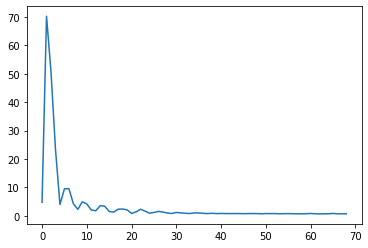

In [26]:
from tqdm.notebook import tqdm
historical_loss = []
# loop over our epochs
for e in range(0, EPOCHS):
  # set the model in training mode
  CNN.train()
  # initialize the total training and validation loss
  totalTrainLoss = 0
  totalValLoss = 0
  # initialize the number of correct predictions in the training
  # and validation step
  trainCorrect = 0
  valCorrect = 0
  # loop over the training set
  for (x, y) in tqdm(trainDL):

    # send the input to the device
    x = x.type(torch.FloatTensor)
    (x, y) = (x.to(device), y.to(device))
    
    # perform a forward pass and calculate the training loss
    pred = CNN(x)
    loss = lossFn(pred, y)
    # zero out the gradients, perform the backpropagation step,
    # and update the weights
    opt.zero_grad()
    loss.backward()
    opt.step()
    # add the loss to the total training loss so far and
    # calculate the number of correct predictions
    totalTrainLoss += loss.detach().cpu().numpy()
    historical_loss.append(loss.detach().cpu().numpy())
    trainCorrect += (pred.argmax(1) == y).type(
      torch.float).sum().item()

  # calculate the average training and validation loss
  avgTrainLoss = totalTrainLoss / len(trainDL.dataset)

  # calculate the training and validation accuracy
  trainCorrect = (trainCorrect / len(trainDL.dataset)*100)

  print(f"Finished epoch = {e} with Accuracy = {trainCorrect} and Loss = {avgTrainLoss}")
  plt.plot(historical_loss)
  plt.show()

# TEST!

In [27]:
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	CNN.eval()
 
  # Make sure that the model is not training
	CNN.train(False)
	
	# initialize a list to store our predictions
	preds = []
	true_labels = []

	# loop over the test set
	for (x, y) in tqdm(testDL):

		true_labels.extend(list(y.detach().cpu().numpy()))

		# send the input to the device
		x = x.type(torch.FloatTensor)
		x = x.to(device)
		# make the predictions and add them to the list
		pred = CNN(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

  0%|          | 0/30 [00:00<?, ?it/s]

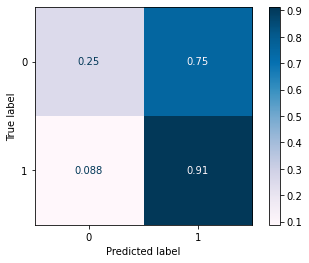

In [28]:
# generate a classification report
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(true_labels, preds, normalize='true', cmap="PuBu")

# Now, Time for some Fine Tuning!!!!

In [29]:
import torchvision  # contains pretrained networks for computer vision
# keypoint detection pretrained, object detection, etc
from torchvision import datasets, models, transforms

model_name = "vgg"

# Number of classes in YOUR dataset (in this case, we have 2 since we have Cats, Dogs)
num_classes = 2

# Batch size
batch_size = 8

# Number of epochs to train for
num_epochs = 1

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [36]:
import time
import copy

def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
    # criterion = loss function
    # optimizer = adam
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()  # Set model to training mode
            
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward + optimize
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader)

        print('Loss: {:.4f}'.format(epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # return the model
    return model

In [31]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [32]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    # torchvision.models
    model_ft = models.vgg11_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

    return model_ft, input_size

In [33]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

# Send the model to GPU
model_ft = model_ft.to(device)

#  Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [37]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = train_model(model_ft, trainDL, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/0
----------
Loss: 75.5804
Training complete in 1m 8s


In [38]:
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model_ft.eval()
 
  # Make sure that the model is not training
	model_ft.train(False)
	
	# initialize a list to store our predictions
	vgg_preds = []
	vgg_true_labels = []

	# loop over the test set
	for (x, y) in tqdm(testDL):

		vgg_true_labels.extend(list(y.detach().cpu().numpy()))

		# send the input to the device
		x = x.type(torch.FloatTensor)
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model_ft(x)
		vgg_preds.extend(pred.argmax(axis=1).cpu().numpy())

  0%|          | 0/30 [00:00<?, ?it/s]

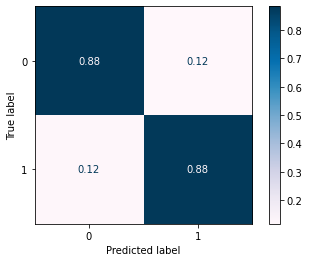

In [39]:
# generate a classification report
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(vgg_true_labels, vgg_preds, normalize='true', cmap="PuBu")